# Colapse all simulation into a unique .feather file

In [3]:
import glob, os
import pandas as pd
import numpy as np
from scipy.stats import ecdf, wasserstein_distance

df_complete_file = 'df_complete_ex1.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_complete_file) ):
    print(f'{df_complete_file} already exists. Reading it.')
    df_all = pd.read_feather(df_complete_file)
else:
    print(f'{df_complete_file} does not exists. Generating it.')
    data_files = glob.glob('../output_SA_ex1/SummaryFile_*.feather')
    df_all = pd.concat((pd.read_feather(file) for file in data_files), ignore_index=True)
    df_all.to_feather(df_complete_file)

params_list = ['cycle_tumor_sat','cycle_tumor_hfm','cycle_tumor_hp',
                   'mechano_tumor_hfm','mechano_tumor_hp',
                   'necrosis_tumor_hfm','necrosis_tumor_hp',
                   'tumor2motile_hfm','tumor2motile_hp',
                   'cycle_motile_sat', 'cycle_motile_hfm', 'cycle_motile_hp',
                   'mechano_motile_hfm', 'mechano_motile_hp',
                   'necrosis_motile_hfm', 'necrosis_motile_hp',
                   'motile2tumor_sat', 'motile2tumor_hfm', 'motile2tumor_hp']
df_all # 183920 rows = 152 samples * 10 repplicates * 121 time points

df_complete_ex1.feather already exists. Reading it.


,time,replicate,sample,runtime,tumor_live,tumor_dead,motile_live,motile_dead,dist_tumor_live,dist_tumor_dead,...,cycle_motile_sat,cycle_motile_hfm,cycle_motile_hp,mechano_motile_hfm,mechano_motile_hp,necrosis_motile_hfm,necrosis_motile_hp,motile2tumor_sat,motile2tumor_hfm,motile2tumor_hp
0,0.0,4,107,0.000019,2000,0,0,0,"[77.9878646113564, 257.21390187394763, 225.465...",[],...,0.00056,17.2,3.2,0.2,2.28,3.00,6.4,0.004,5.4,6.4
1,60.0,4,107,1.009026,1924,37,49,1,"[73.18934881001186, 259.1817177692407, 232.719...","[330.86966679363417, 209.19706740196096, 58.95...",...,0.00056,17.2,3.2,0.2,2.28,3.00,6.4,0.004,5.4,6.4
2,120.0,4,107,2.049730,1879,58,76,2,"[76.92169181692447, 259.72315067448596, 235.02...","[330.5687468157667, 30.294812203799566, 213.07...",...,0.00056,17.2,3.2,0.2,2.28,3.00,6.4,0.004,5.4,6.4
3,180.0,4,107,3.075330,1830,76,108,4,"[260.4245099355263, 236.34011074261932, 316.35...","[78.87116893672855, 330.61392855684596, 33.554...",...,0.00056,17.2,3.2,0.2,2.28,3.00,6.4,0.004,5.4,6.4
4,240.0,4,107,4.100399,1794,94,129,7,"[261.87585400551524, 237.74671696750653, 316.2...","[82.1607379287901, 113.9423668014618, 330.6959...",...,0.00056,17.2,3.2,0.2,2.28,3.00,6.4,0.004,5.4,6.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185125,6960.0,6,114,170.303300,1844,338,105,80,"[294.68509713812335, 402.9800486714981, 322.24...","[80.23184379399002, 234.14188836524113, 98.885...",...,0.00056,17.2,3.2,0.2,2.40,3.03,6.4,0.004,5.4,6.4
185126,7020.0,6,114,171.951886,1855,340,100,80,"[294.32372585043333, 403.2534543617331, 321.72...","[81.42580074308741, 233.6395739895814, 99.4900...",...,0.00056,17.2,3.2,0.2,2.40,3.03,6.4,0.004,5.4,6.4
185127,7080.0,6,114,173.594218,1865,335,99,80,"[293.9464474465499, 403.42077302881916, 322.11...","[81.05038322056353, 233.80589350543497, 99.226...",...,0.00056,17.2,3.2,0.2,2.40,3.03,6.4,0.004,5.4,6.4
185128,7140.0,6,114,175.233674,1877,338,90,80,"[293.51856763888105, 403.570533588793, 322.898...","[80.20369078836694, 234.25601638624298, 98.829...",...,0.00056,17.2,3.2,0.2,2.40,3.03,6.4,0.004,5.4,6.4


# Define the QoIs: AUC of each mean population, weithed mean and pooled std of distance from the center in the last time

- Population: store the population of each cell type over time.
    - Summary over time and replicates: Area under curve (AUC) of the average populations.
- Invasion: Distance of cells from the center - provides insights into the spatial distribution and invasion characteristics of the cells.
    - Summary over time and replicates: Pooling the distances from replicates and calculate the Wassertein distance between tumor and motile.


In [15]:
df_summary_file = 'df_summary_ex1.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_summary_file) ):
    print(f'{df_summary_file} already exists. Reading it.')
    df_summary = pd.read_feather(df_summary_file)
else:
    print(f'{df_summary_file} does not exists. Generating it.')

    # Exclude columns with numpy arrays before calculating the mean
    exclude_cols = ['dist_tumor_live', 'dist_tumor_dead', 'dist_motile_live', 'dist_motile_dead']
    df_summary_temp = df_all.drop(columns=exclude_cols).groupby(['sample', 'time'], as_index=False).mean()
    df_summary_temp = df_summary_temp.drop(columns=['replicate'])

    # Replace the mean of distributions to concatenate each replicate samples - row dimension of samples x time points
    for col in exclude_cols:
        concatenated = df_all.groupby(['sample', 'time'])[col].apply(
            lambda x: np.concatenate([y for y in x if y.size > 0 and y.ndim > 0]) if any(y.size > 0 and y.ndim > 0 for y in x) else np.array([])
        ).reset_index(drop=True)
        df_summary_temp[col] = concatenated
    
    # Function to calculate AUC using trapezoidal rule for trajectories
    def calculate_auc_multiple(group):
        auc_values = {}
        for col in ['tumor_live', 'tumor_dead', 'motile_live', 'motile_dead']: # QoI columns of cell population  
            mask_notna = group[col].notna()  
            auc_values[f'AUC_{col}'] = np.trapezoid(group[col][mask_notna], group['time'][mask_notna])
        return pd.Series(auc_values)
    # Group by 'Sample_ID' then calculate AUC for each QOI - row dimension of samples
    df_auc = df_summary_temp.groupby(['sample']).apply(calculate_auc_multiple).reset_index() # calculate the AUC for each QOI
    
    # Function to calculate Wasserstein distance between tumor and motile cells 
    def calculate_wassertein_dist(group):
        wasserstein_values = {}
        # Define empirical distributions of tumor and motile cells
        emp_liveTumor_cdf = ecdf(group['tumor_live'].to_numpy())
        emp_liveMotile_cdf = ecdf(group['motile_live'].to_numpy())
        wasserstein_values['Wasserstein_dist'] = wasserstein_distance(emp_liveTumor_cdf.cdf.quantiles, emp_liveMotile_cdf.cdf.quantiles, emp_liveTumor_cdf.cdf.probabilities, emp_liveMotile_cdf.cdf.probabilities)
        return pd.Series(wasserstein_values)
    # Group by 'Sample_ID' then calculate Wasserstein distance between tumor and motile cells - row dimension of samples
    df_distance = df_summary_temp[ df_summary_temp['time'] == 7200.0 ].groupby(['sample']).apply(calculate_wassertein_dist).reset_index()

    # Merge the AUC values and Wasserstein distance to the summary dataframe
    df_summary = df_auc.merge(df_distance, on=['sample'])
    
    # Merge the parameters to the summary dataframe
    df_summary = df_summary.merge(df_summary_temp[ df_summary_temp['time'] == 7200.0 ][['sample']+ params_list], on=['sample'])


    df_summary.to_feather(df_summary_file)

df_summary

df_summary_ex1.feather does not exists. Generating it.


/tmp/ipykernel_77585/1622252816.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_auc = df_summary_temp.groupby(['sample']).apply(calculate_auc_multiple).reset_index() # calculate the AUC for each QOI
/tmp/ipykernel_77585/1622252816.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_distance = df_summary_temp[ df_summary_temp['time'] == 7200.0 ].groupby(['sample']).apply(calculate_wassertein_dist

,sample,AUC_tumor_live,AUC_tumor_dead,AUC_motile_live,AUC_motile_dead,Wasserstein_dist,cycle_tumor_sat,cycle_tumor_hfm,cycle_tumor_hp,mechano_tumor_hfm,...,cycle_motile_sat,cycle_motile_hfm,cycle_motile_hp,mechano_motile_hfm,mechano_motile_hp,necrosis_motile_hfm,necrosis_motile_hp,motile2tumor_sat,motile2tumor_hfm,motile2tumor_hp
0,0,12274602.0,1838106.0,825684.0,441906.0,1735.0,0.000560,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,6.40
1,1,12262137.0,1871406.0,825015.0,420876.0,1737.4,0.000554,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,6.40
2,2,12271776.0,1862319.0,812616.0,444870.0,1727.4,0.000566,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,6.40
3,3,12273930.0,1845969.0,823431.0,422313.0,1731.7,0.000532,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,6.40
4,4,12316320.0,1815498.0,851280.0,427005.0,1733.0,0.000588,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,6.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,148,12338649.0,1822278.0,849003.0,441480.0,1739.8,0.000560,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,6.72
149,149,12290523.0,1833006.0,834018.0,428778.0,1735.3,0.000560,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,5.76
150,150,12298029.0,1804083.0,849603.0,444039.0,1733.2,0.000560,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,7.04
151,151,12283353.0,1851759.0,829011.0,408270.0,1717.8,0.000560,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,5.12


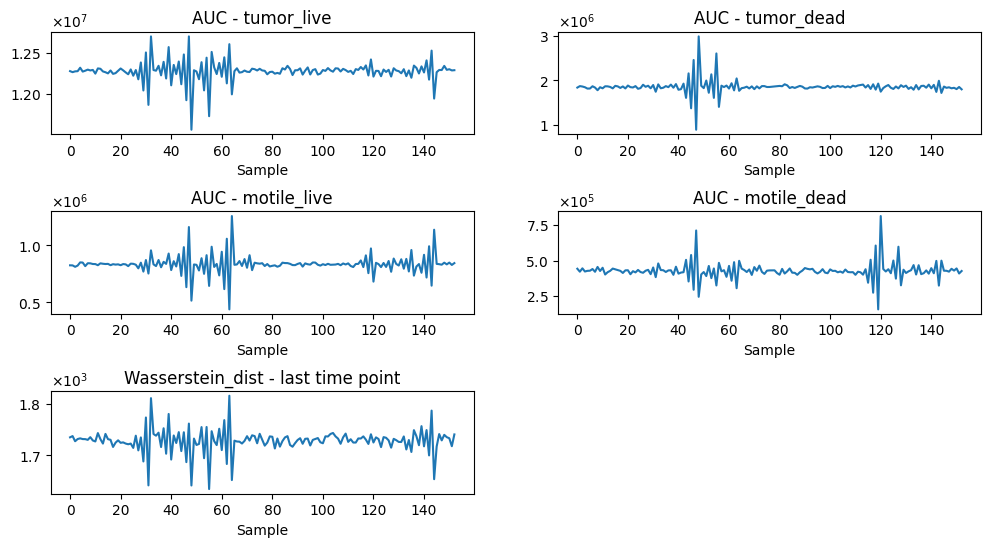

In [16]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.75)
axes[0, 0].plot(df_summary['sample'], df_summary['AUC_tumor_live'])
axes[0, 0].set_title('AUC - tumor_live')
axes[0, 0].set_xlabel('Sample')
axes[0, 0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0, 0].yaxis.major.formatter._useMathText = True

axes[0, 1].plot(df_summary['sample'], df_summary['AUC_tumor_dead'])
axes[0, 1].set_title('AUC - tumor_dead')
axes[0, 1].set_xlabel('Sample')
axes[0, 1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0, 1].yaxis.major.formatter._useMathText = True

axes[1, 0].plot(df_summary['sample'], df_summary['AUC_motile_live'])
axes[1, 0].set_title('AUC - motile_live')
axes[1, 0].set_xlabel('Sample')
axes[1, 0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[1, 0].yaxis.major.formatter._useMathText = True

axes[1, 1].plot(df_summary['sample'], df_summary['AUC_motile_dead'])
axes[1, 1].set_title('AUC - motile_dead')
axes[1, 1].set_xlabel('Sample')
axes[1, 1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[1, 1].yaxis.major.formatter._useMathText = True

axes[2, 0].plot(df_summary['sample'], df_summary['Wasserstein_dist'])
axes[2, 0].set_title('Wasserstein_dist - last time point')
axes[2, 0].set_xlabel('Sample')
axes[2, 0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[2, 0].yaxis.major.formatter._useMathText = True

axes[2, 1].remove()

plt.show()

# Local sensitivity analysis: 
Give $\theta^\star$ as the reference parameter set, we added a multiplicative perturbation $\delta$, which
$$\theta_i = \theta^\star \times (1\pm \delta), \quad \delta = \{0.01, 0.05, 0.1, 0.2\}$$
Relative sensitivity:
$$S_{\theta_i} = \dfrac{f(\theta_i)-f(\theta^\star)}{f(\theta^\star)}\cdot \dfrac{\theta^\star}{\theta_i - \theta^\star}$$

- $S>0:$ As the parameter increases, the output also increases.
- $S<0:$ As the parameter increases, the output decreases.
- $S=0:$ The output is insensitive to changes in the parameter.
- $∣S∣≫1:$ The output is highly sensitive to the parameter; small changes in the parameter will cause large changes in the output.
- $∣S∣≪1:$ The output is relatively insensitive to the parameter; large changes in the parameter will have little effect on the output.

In [63]:
import os 

print(os.getcwd())
# Change the directory
os.chdir("/N/slate/hlimadar/grammar_samples")
print(os.getcwd())

sample_ref = 0 # Sample with reference parameters
print('Sample with reference parameters: ', df_summary.iloc[sample_ref][params_list].values)

# Calculate the sensitivity index
QoIs_list = ['AUC_tumor_live', 'AUC_tumor_dead', 'AUC_motile_live', 'AUC_motile_dead', 'Wasserstein_dist']
# Function to calculate SI using
def calculate_SI_multiple():
    sensitivity_index = {}
    # Calculate the delta of parameters
    non_zero_values = []; non_zero_params= []
    relative_change_params = (df_summary[params_list] - df_summary.iloc[sample_ref][params_list].values) / np.where(df_summary.iloc[sample_ref][params_list].values != 0, df_summary.iloc[sample_ref][params_list].values, 1)
    for index, row in relative_change_params.iterrows():
        # First index is the reference sample - include the value 1 and skip it
        if index == sample_ref: non_zero_values.append(1); non_zero_params.append('Reference'); continue
        # Get the non-zero values in the row
        non_zero_row_values = row[row != 0.0]
        # Check if there is exactly one non-zero value
        if len(non_zero_row_values) == 1: non_zero_values.append(non_zero_row_values.iloc[0])
        else: raise ValueError(f"Row {index} contains more than one non-zero value or all values are zero. Non zero: {non_zero_row_values} - Row: {row.values}")
        # Parameter name with non-zero value
        non_zero_params.append(non_zero_row_values.index[0])
    relative_change_params_1d = pd.DataFrame(non_zero_values, columns=['NonZeroValues'])
    sensitivity_index['SA_parameter'] = np.array(non_zero_params)
    sensitivity_index['SA_delta'] = relative_change_params_1d.to_numpy()[:,0]
    # Calculate the delta of QoIs
    relative_change_qois = (df_summary[QoIs_list] - df_summary.iloc[sample_ref][QoIs_list].values) / np.where(df_summary.iloc[sample_ref][QoIs_list].values != 0, df_summary.iloc[sample_ref][QoIs_list].values, 1)
    for id_qoi, qoi in enumerate(QoIs_list): 
        sensitivity_index[f'SI_{qoi}'] = relative_change_qois.to_numpy()[:,id_qoi]/sensitivity_index['SA_delta']
    
    # Change the delta of reference value to 0
    sensitivity_index.iloc[0]['SA_delta'] = 0
    return pd.DataFrame(sensitivity_index)

# Group by 'Sample_ID' then calculate AUC for each QOI - row dimension of samples
df_SI = calculate_SI_multiple() # calculate the AUC for each QOI
df_summary = pd.concat([df_summary['sample'], df_SI], axis=1)

df_summary

/N/slate/hlimadar/grammar_samples
/N/slate/hlimadar/grammar_samples
Sample with reference parameters:  [np.float64(0.0005600000000000001) np.float64(17.2) np.float64(3.2)
 np.float64(0.2) np.float64(2.4000000000000004) np.float64(3.0)
 np.float64(6.4) np.float64(5.4) np.float64(6.4)
 np.float64(0.0005600000000000001) np.float64(17.2) np.float64(3.2)
 np.float64(0.2) np.float64(2.4000000000000004) np.float64(3.0)
 np.float64(6.4) np.float64(0.004) np.float64(5.4) np.float64(6.4)]


,sample,SA_parameter,SA_delta,SI_AUC_tumor_live,SI_AUC_tumor_dead,SI_AUC_motile_live,SI_AUC_motile_dead,SI_Wasserstein_dist
0,0,Reference,1.00,0.0,0.0,0.0,0.0,0.0
1,1,cycle_tumor_sat,-0.01,0.101551,-1.811647,0.081024,4.758931,-0.138329
2,2,cycle_tumor_sat,0.01,-0.023023,1.31728,-1.582688,0.670731,-0.43804
3,3,cycle_tumor_sat,-0.05,0.001095,-0.085555,0.054573,0.88675,0.03804
4,4,cycle_tumor_sat,0.05,0.067975,-0.245992,0.619995,-0.674397,-0.023055
...,...,...,...,...,...,...,...,...
148,148,motile2tumor_hp,0.05,0.104357,-0.172221,0.564841,-0.01928,0.055331
149,149,motile2tumor_hp,-0.10,-0.012971,0.027746,-0.100934,0.297077,-0.001729
150,150,motile2tumor_hp,0.10,0.019086,-0.185098,0.289687,0.048268,-0.010375
151,151,motile2tumor_hp,-0.20,-0.003565,-0.037139,-0.020147,0.380579,0.049568


In [ ]:
import seaborn as sns

# Sample DataFrame for demonstration
data = {
    'SA_parameter': [f'param{i+1}' for i in range(25)],
    'SI_QoI1': [0.5, 0.3, 0.7, 0.2, 0.4, 0.6, 0.2, 0.8, 0.3, 0.5, 0.6, 0.4, 0.5, 0.3, 0.7, 0.2, 0.4, 0.6, 0.2, 0.8, 0.3, 0.5, 0.6, 0.4, 0.5],
    'SI_QoI2': [0.4, 0.6, 0.2, 0.8, 0.3, 0.5, 0.6, 0.4, 0.5, 0.3, 0.7, 0.2, 0.4, 0.6, 0.2, 0.8, 0.3, 0.5, 0.6, 0.4, 0.5, 0.3, 0.7, 0.2, 0.4],
    'SI_QoI3': [0.3, 0.5, 0.6, 0.4, 0.5, 0.3, 0.7, 0.2, 0.4, 0.6, 0.2, 0.8, 0.3, 0.5, 0.6, 0.4, 0.5, 0.3, 0.7, 0.2, 0.4, 0.6, 0.2, 0.8, 0.3],
    'SI_QoI4': [0.6, 0.4, 0.5, 0.3, 0.7, 0.2, 0.4, 0.6, 0.2, 0.8, 0.3, 0.5, 0.6, 0.4, 0.5, 0.3, 0.7, 0.2, 0.4, 0.6, 0.2, 0.8, 0.3, 0.5, 0.6],
    'SI_QoI5': [0.2, 0.8, 0.3, 0.5, 0.6, 0.4, 0.5, 0.3, 0.7, 0.2, 0.4, 0.6, 0.2, 0.8, 0.3, 0.5, 0.6, 0.4, 0.5, 0.3, 0.7, 0.2, 0.4, 0.6, 0.2]
}
df = pd.DataFrame(data)


# Pivot the DataFrame to get the desired format for the heatmap
df_melted = df.melt(id_vars=['SA_parameter'], var_name='QoI', value_name='Sensitivity Index')
df_pivot = df_melted.pivot(index='SA_parameter', columns='QoI', values='Sensitivity Index')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_summary, annot=True, cmap='coolwarm', cbar_kws={'label': 'Sensitivity Index'})
plt.xlabel('Quality of Interest (QoI)')
plt.ylabel('Parameters')
plt.title('Sensitivity Index Heatmap for 25 Parameters and 5 QoIs')
plt.show()